# Example use case of the NMC

This notebook provides a simple use case of the Neural Mechanistic Causal (NMC) discovery method for time series data sampled from an underlying dynamical system, based on our paper *"Mechanistic Causal Discovery using Neural ODEs"*.

## What is the neural mechanistic causal discovery method?

It is a continuous-time alternative to the more common discrete-time causal models, such as Granger causality. While appealing due to their simplicity, discrete-time methods are at odds with the continuous-time nature of the unfolding processes over time, and cumbersome to interpret with irregularly sampled time series or with processes observed at a scale that does not reflect that of causal associations. 

Here, we propose to model causality explicitly as a latent mechanism continuously in time using the mathematics of differential equations. The objective then is to consistently recover causal interactions in infinitesimal intervals of time. The key advantages of the resulting causal discovery algorithm are that it is directly applicable to the general setting of irregularly-sampled multivariate time series, it does not impose constraints on the non-linearities or dimensionality of the underlying system, and under appropriate conditions, identifies causal associations exactly.

Let us import some necessary packages before illustrating the use of NMC.

In [1]:
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output

sys.path.append('../')
from source.utils import simulate_lorenz_96, compare_graphs
import source.utils as utils
import source.NMC as models
import importlib

We will use the Lorenz model as the underlying data generating mechanism, with 10 variables and 1000 regularly-sampled observations.

In [10]:
# Simulate data
p = 10
T = 1000
num_points = T
data, GC= simulate_lorenz_96(p, T=T, delta_t=0.05,sd=0.0, F=10)
    
# format for NeuralODE
times = np.linspace(0, T, num_points)
times_np = np.hstack([times[:, None]])
times = torch.from_numpy(times_np[:, :, None].astype(np.float32))
data = torch.from_numpy(data[:, None, :].astype(np.float32))

Let us plot the data. The right-most panel is the binary matrix indicating the presence / absence of edges in the underlying causal graph. This is our target.

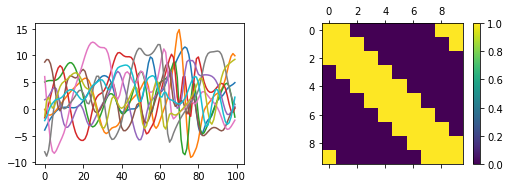

In [6]:
fig, axs = plt.subplots(1,2, figsize=(7, 2.3))
fig.tight_layout(pad=0.2, w_pad=2, h_pad=3)
axs[0].plot(data[:100].squeeze())
cax = axs[1].matshow(GC)
fig.colorbar(cax)
plt.show()

We will now define the model

In [7]:
importlib.reload(models)

# function specification
func = models.MLPODEF(dims=[p, 12, 1],GL_reg=0.1)

And train using adjoint backpropagation to approximate the observed trajectories. The intermediate plots during training show in the leftmost panel: the observed data, in the middle panel: the approximated trajectories, in the rightmost panel: the approximated causal structure.

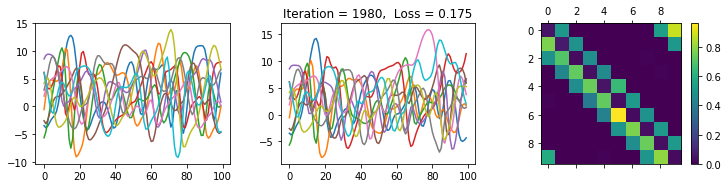

In [11]:
importlib.reload(models)

# Group Lasso training
models.train(func,data,n_steps=1000,plot_freq=20)

# Adaptive Group lasso training
weights = func.group_weights()
func.GL_reg *= (1 / weights)
func.reset_parameters()
models.train(func,data,n_steps=1000,plot_freq=20)

Let us inspect the recovered graph and compute true positive rates (TPR) and false discovery rates (FDR)

In [12]:
# inspect estimated causal graph and SHD computation
W_est = func.causal_graph(w_threshold=0.)
print(W_est)
print('TPR and FDR of our estimate with respect to truth:')
compare_graphs(GC, W_est) 

[[0.05 0.5  0.01 0.   0.   0.   0.   0.01 0.54 0.87]
 [0.79 0.05 0.49 0.   0.   0.   0.   0.   0.   0.51]
 [0.47 0.7  0.03 0.47 0.   0.   0.   0.   0.   0.  ]
 [0.   0.46 0.73 0.03 0.46 0.   0.   0.   0.01 0.  ]
 [0.   0.   0.48 0.72 0.04 0.63 0.   0.01 0.   0.  ]
 [0.   0.   0.   0.4  0.74 0.05 0.53 0.   0.   0.  ]
 [0.   0.   0.   0.   0.41 0.95 0.03 0.5  0.   0.  ]
 [0.   0.   0.   0.   0.   0.5  0.77 0.03 0.53 0.  ]
 [0.   0.   0.   0.   0.   0.   0.48 0.75 0.03 0.52]
 [0.57 0.   0.   0.   0.   0.   0.   0.5  0.81 0.04]]
TPR and FDR of our estimate with respect to truth:


(1.0, 0.09090909090909091)

A plot is perhaps more informative

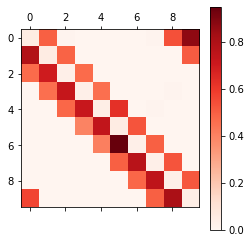

In [13]:
graph = func.causal_graph(w_threshold=0.)
plt.matshow(graph,cmap='Reds')
plt.colorbar()
plt.show()